# <center>STYLING DEL NOTEBOOK</center>

In [89]:
from IPython.core.display import HTML

HTML("""<style>
    @import url('https://fonts.googleapis.com/css?family=Montserrat&display=swap');
     
    * {
        font-family: 'Montserrat', 'Arial', sans-serif;
        text-align: left;
        line-height: 2em;
    }

</style>""")

# <center>ELENCO IMPORT</center>

In [90]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
import cv2 as cv
import math

os.environ["QT_QPA_PLATFORM"] = "xcb"

from itertools import zip_longest 
from IPython.display import display

# <center>IMPOSTAZIONE PERCORSI</center>

In [91]:
BASE_DIR = "../BD-Image-Segmentation-Comp/" 
TRAIN_DIR = os.path.join(BASE_DIR, 'train')
TRAIN_CSV = os.path.join(BASE_DIR, 'train.csv')

# <center>1 &dash; OPERAZIONI SUL FILE **train.csv**</center>

## CONSIDERAZIONI PRELIMINARI

Inizialmente, proviamo ad aprire il contenuto del file **train.csv**, fornito dai creatori della competizione, per osservarne il contenuto e avere una comprensione preliminare del problema.

In [92]:
train_df = pd.read_csv(TRAIN_CSV)

train_df.head()

,id,class,segmentation
0,case123_day20_slice_0001,large_bowel,NaN
1,case123_day20_slice_0001,small_bowel,NaN
2,case123_day20_slice_0001,stomach,NaN
3,case123_day20_slice_0002,large_bowel,NaN
4,case123_day20_slice_0002,small_bowel,NaN


In [93]:
len(train_df)

115488

Il file presenta una struttura formata da 115488 righe per 3 colonne, ossia:

* **id**, ossia l'identificativo associato ad un frame dell'acquisizione fatta in un dato giorno per uno specifico caso;
* **class**, cio&eacute; l'organo presente nella scansione;
* **segmentation**, ossia il segmento di immagine corrispondente all'organo individuato nella classe.

La prima cosa che vogliamo andare a vedere è, per ogni classe, il numero di elementi del training set ad essa.

In [94]:
class_counts = train_df['class'].value_counts()

class_counts.values

array([38496, 38496, 38496])

Creazione del grafico a barre con colori personalizzati per ogni classe

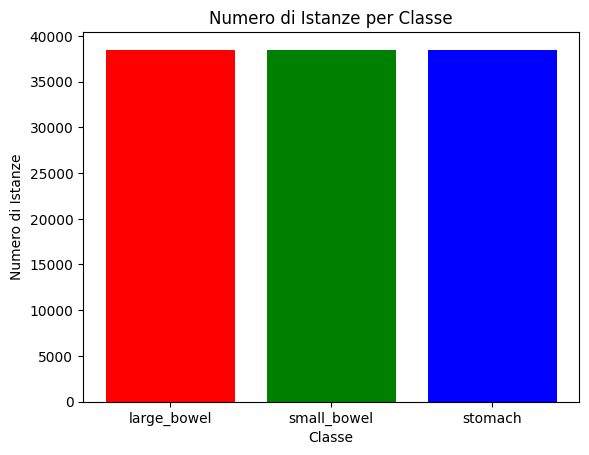

In [95]:
colors = ['red', 'green', 'blue']
plt.bar(class_counts.index, class_counts.values, color=[colors[i] for i in range(len(class_counts))])

# Aggiunta delle etichette dell'asse x e y e del titolo del grafico
plt.xlabel('Classe')
plt.ylabel('Numero di Istanze')
plt.title('Numero di Istanze per Classe')

# Mostrare il grafico
plt.show()

Quello che notiamo è che il numero di elementi appartenenti ad ogni classe, **large_bowel**, **small_bowel** e **stomach**, è lo stesso, 38496, cosa ipotizzabile *ad occhio* nel dataframe precedentemente importato.

L'altra colonna rilevante del dataframe è quella di *segmentation*, che viene usata per indicare le maschere corrispondenti all'organo classificato. Come prima cosa, vogliamo evidenziare solo le istanze del DataFrame che hanno una segmentazione non nulla (i.e. diversa da NaN).

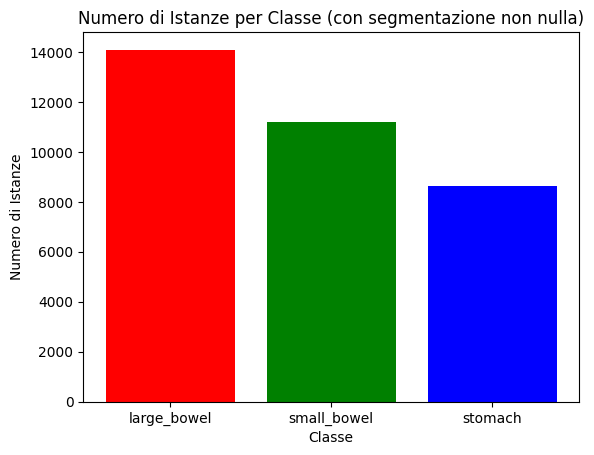

In [96]:
# Eliminazione delle righe con valori mancanti nella colonna "segmentation"
df_filtered = train_df.dropna(subset=['segmentation'])

# Calcolo del numero di istanze per ogni classe nella colonna "class" del DataFrame filtrato
class_counts = df_filtered['class'].value_counts()

# Creazione del grafico a barre con colori personalizzati per ogni classe
colors = ['red', 'green', 'blue']
plt.bar(class_counts.index, class_counts.values, color=[colors[i] for i in range(len(class_counts))])

# Aggiunta delle etichette dell'asse x e y e del titolo del grafico
plt.xlabel('Classe')
plt.ylabel('Numero di Istanze')
plt.title('Numero di Istanze per Classe (con segmentazione non nulla)')

# Mostrare il grafico
plt.show()

Abbiamo costruito, a partire dal dataframe originale, un secondo dataframe, chiamato *df_filtered* tramite la funzione 
`dropna()` di `pandas.Dataframe` per eliminare le righe con valori mancanti (i.e. NaN) nella colonna *segmentation*.

Successivamente, in maniera analoga al calcolo delle istanze di classe, abbiamo utilizzato il dataframe appena creato per calcolare il numero 
di istanze per ogni classe nella colonna *class*, utilizzando la funzione `value_counts()` di `pandas.Dataframe`. 

Infine, abbiamo creato un grafico a barre con i risultati e abbiamo aggiunto le etichette dell'asse x, dell'asse y e del titolo del grafico.

## PRIMA PREPARAZIONE

L'obiettivo di questa seconda parte di operazioni sul file **train.csv** è quello di estrarre delle informazioni che possano tornare utili in fase di analisi del problema e di eventuali operazioni di *data cleaning* (visto l'elevato numero di slice prive di maschere è facile aspettarsi un calo drastico delle dimensioni del dataset).

Inizialmente, effettuiamo una semplice conversione di notazione per la classificazione: piuttosto che usare una label categorica, passiamo ad una classificazione per valori interi discreti.

In [97]:
class_mapping = {'large_bowel': 0, 'small_bowel': 1, 'stomach': 2}

train_df['class'] = train_df['class'].replace(class_mapping)

Successivamente, a partire dalla colonna **id** del dataframe di partenza, si può osservare come ogni riga contenga informazioni circa la categorizzazione per numero del **caso** clinico, per **giornata** di osservazione e per **numero di frame** dell'acquisizione. L'obiettivo diventa, quindi, quello di estrarre le suddette informazioni e di rielaborare il dataframe.

Inizialmente, elaboriamo, per ogni riga, il valore di **id**, in modo da estrarre una lista di informazioni

In [98]:
splits = train_df['id'].str.split("_", n = 4, expand = True)

splits.head()

,0,1,2,3
0,case123,day20,slice,0001
1,case123,day20,slice,0001
2,case123,day20,slice,0001
3,case123,day20,slice,0002
4,case123,day20,slice,0002


Come si può vedere nella tabella precedente, le informazioni che possiamo estrarre si trovano nei chunk 0, 1 e 3. 

Ciò che ci interessa è, però, dare un'impostazione ai dati più quantitativa, per cui dobbiamo estrarre dai chunk 0 e 1, rispettivamente, il numero del caso e della giornata di osservazione, mentre il chunk 3 va solo inteso come un numero intero, per eliminare gli 0 iniziali.

In [99]:
train_df['case_id'] = splits[0]
train_df['day_id'] = splits[1]
train_df['slice_id'] = splits[3].astype(int)

train_df['case_id'] = train_df['case_id'].str.replace('case', '').astype(int) 
train_df['day_id'] = train_df['day_id'].str.replace('day', '').astype(int)

train_df.head()

,id,class,segmentation,case_id,day_id,slice_id
0,case123_day20_slice_0001,0,NaN,123,20,1
1,case123_day20_slice_0001,1,NaN,123,20,1
2,case123_day20_slice_0001,2,NaN,123,20,1
3,case123_day20_slice_0002,0,NaN,123,20,2
4,case123_day20_slice_0002,1,NaN,123,20,2


Adesso vogliamo compattare il dataframe, in modo che la singola riga contenga le informazioni della coppia `(class, segmentation)` per la tripla `(large_bowel, small_bowel, stomach)`, e ordinarlo in ordine crescente per numero del caso, giornata di osservazione e identificativo della scansione. Per farlo, dobbiamo:

* Rimuovere le colonne *class* e *segmentation* e salvarlo in due liste opportune

In [100]:
classe = train_df.pop('class')
segmentation = train_df.pop('segmentation')

* Raggruppare gli elementi in gruppi da tre e rimuovere i duplicati per *id*

In [101]:
grouped_segmentation = list(zip_longest(*[iter(segmentation)]*3, fillvalue=None))
grouped_class = list(zip_longest(*[iter(classe)]*3, fillvalue=None))

train_df = train_df.drop_duplicates(subset=['id'])

train_df.insert(len(train_df.columns), 'class', grouped_class)
train_df.insert(len(train_df.columns), 'segmentation', grouped_segmentation)

* Ordinare il dataframe per *case_id*, *day_id* e *slice_id*

In [102]:
train_df = train_df.sort_values(by=['case_id', 'day_id', 'slice_id'], ascending=True).reset_index(drop=True)

train_df.head()

,id,case_id,day_id,slice_id,class,segmentation
0,case2_day1_slice_0001,2,1,1,"(0, 1, 2)","(nan, nan, nan)"
1,case2_day1_slice_0002,2,1,2,"(0, 1, 2)","(nan, nan, nan)"
2,case2_day1_slice_0003,2,1,3,"(0, 1, 2)","(nan, nan, nan)"
3,case2_day1_slice_0004,2,1,4,"(0, 1, 2)","(nan, nan, nan)"
4,case2_day1_slice_0005,2,1,5,"(0, 1, 2)","(nan, nan, nan)"


# <center>2 &dash; RACCOLTA E INVENTARIO DELLE IMMAGINI</center>

Dopo aver osservato alcuni aspetti interessanti sui dati forniti dal problema, vogliamo andare ad indagare maggiormente sulle immagini delle varie scansioni. Per evitare di avere un dataframe poco leggibile, umanamente parlando, ricorriamo ad un secondo dataframe, realizzato da zero, a partire dai percorsi estratti dalla cartella *train* e associati alle *scans*.

In [103]:
list_slices = glob.glob(TRAIN_DIR+'/*/*/scans/*.png')

image_details = pd.DataFrame({'path':list_slices})

image_details.head()

,path
0,../BD-Image-Segmentation-Comp/train/case149/ca...
1,../BD-Image-Segmentation-Comp/train/case149/ca...
2,../BD-Image-Segmentation-Comp/train/case149/ca...
3,../BD-Image-Segmentation-Comp/train/case149/ca...
4,../BD-Image-Segmentation-Comp/train/case149/ca...


Adesso, a partire dai persorsi individuati, possiamo andare ad estrarre le informazioni che ci interessa possano essere associati alle singole immagini:

1. **Numero del caso**
2. **Giorno di osservazione**
3. **Numero della slice**
4. **Altezza dell'immagine**
5. **Larghezza dell'immagine**
6. **Altezza del singolo pixel**
7. **Larghezza del singolo pixel**

In [104]:
splits = image_details['path'].str.split("/", n = 7, expand = True)

image_details[['case_id', 'day_id']] = splits[4].str.split("_", expand = True)

image_details['case_id'] = image_details['case_id'].str.replace('case', '').astype(int) 
image_details['day_id'] = image_details['day_id'].str.replace('day', '').astype(int)

image_details['slice_name'] = splits[6]

slice_info = image_details['slice_name'].str.split(n=6, expand=True, pat="_")

image_details['slice_id'] = slice_info[1].astype(int)

image_details['width'] = slice_info[2].astype(int)
image_details['height'] = slice_info[3].astype(int)

image_details['width_px'] = slice_info[4].astype(float)

image_details['height_px'] = slice_info[5].str.replace('.png', '', regex=False).astype(float)

splits[5] = splits[5].str.replace('scans', 'masks')
splits[6] = splits[6].str.replace('slice', 'mask_slice')

percorsi_cartelle = splits.drop(columns=[6])
percorsi_cartelle = percorsi_cartelle.apply(lambda x: '/'.join(x.astype(str)), axis=1)

percorsi_maschere = splits.apply(lambda x: '/'.join(x.astype(str)), axis=1)

image_details.insert(1, 'mask_path', percorsi_maschere)

Ordiniamo, quindi, in ordine **crescente** per numero del caso, giornata di osservazione e numero della slice, il dataframe appena costruito.

In [105]:
image_details = image_details.sort_values(by=['case_id', 'day_id', 'slice_id'], ascending=True).reset_index(drop=True)

image_details.head()

,path,mask_path,case_id,day_id,slice_name,slice_id,width,height,width_px,height_px
0,../BD-Image-Segmentation-Comp/train/case2/case...,../BD-Image-Segmentation-Comp/train/case2/case...,2,1,slice_0001_266_266_1.50_1.50.png,1,266,266,1.5,1.5
1,../BD-Image-Segmentation-Comp/train/case2/case...,../BD-Image-Segmentation-Comp/train/case2/case...,2,1,slice_0002_266_266_1.50_1.50.png,2,266,266,1.5,1.5
2,../BD-Image-Segmentation-Comp/train/case2/case...,../BD-Image-Segmentation-Comp/train/case2/case...,2,1,slice_0003_266_266_1.50_1.50.png,3,266,266,1.5,1.5
3,../BD-Image-Segmentation-Comp/train/case2/case...,../BD-Image-Segmentation-Comp/train/case2/case...,2,1,slice_0004_266_266_1.50_1.50.png,4,266,266,1.5,1.5
4,../BD-Image-Segmentation-Comp/train/case2/case...,../BD-Image-Segmentation-Comp/train/case2/case...,2,1,slice_0005_266_266_1.50_1.50.png,5,266,266,1.5,1.5


# <center>3 &dash; STATISTICA DELLE IMMAGINI</center>

A seguito di ispezione visiva, abbiamo notato che alcune immagini erano, di base, qualitativamente migliori di altre. Quello che abbiamo fatto, allora, è stato cercare di trovare qualche correlazione tra le caratteristiche dell'immagine e la sua qualità.

## DISTRIBUZIONE DELLE IMMAGINI IN BASE ALLA PROFONDIT&Agrave; DEI PIXEL

Il dataframe ci permette di evidenziare, di base, la presenza di due possibili valori per la profondità delle immagini, ossia $1.50\text{ mm}$ e $1.63\text{ mm}$. Innanzitutto, abbiamo pensato fosse cosa buona andare ad evidenziare la distribuzione delle immagini sulla base dei suddetti valori.

In [106]:
num_images_150 = image_details.loc[(image_details['width_px'] == 1.50) & (image_details['height_px'] == 1.50)].shape[0]
print(f"Il numero di immagini con pixel di altezza e larghezza pari a 1.50 mm è {num_images_150}")

num_images_163 = image_details.loc[(image_details['width_px'] == 1.63) & (image_details['height_px'] == 1.63)].shape[0]
print(f"Il numero di immagini con pixel di altezza e larghezza pari a 1.63 mm è {num_images_163}")

print(f"Il numero complessivo di immagini è {len(image_details)}, esattamente pari a {num_images_150} + {num_images_163}")

Il numero di immagini con pixel di altezza e larghezza pari a 1.50 mm è 37296
Il numero di immagini con pixel di altezza e larghezza pari a 1.63 mm è 1200
Il numero complessivo di immagini è 38496, esattamente pari a 37296 + 1200


Avendo controllato che la somma di entrambi i numeri resituisse esattamente 38496, il numero complessivo di immagini, abbiamo rappresentato in grafico tale distribuzione.

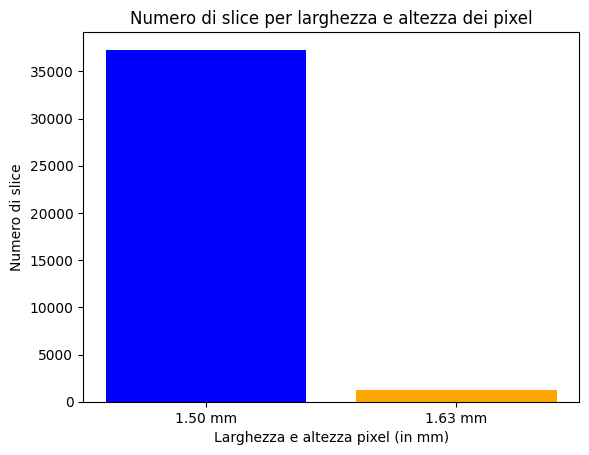

In [107]:
labels = ['1.50 mm', '1.63 mm']
num_images = [num_images_150, num_images_163]

colors = ['blue', 'orange']

fig, ax = plt.subplots()
ax.bar(labels, num_images, color=colors)

ax.set_title('Numero di slice per larghezza e altezza dei pixel')
ax.set_xlabel('Larghezza e altezza pixel (in mm)')
ax.set_ylabel('Numero di slice')

plt.show()

L'attenzione verso la profondità dei pixel si giustifica anche attraverso un'intuizione seguita a un'ispezione visiva delle immagini: abbiamo notato che le immagini con pixel profondi $1.63 \text{ mm}$ sono tendenzialmente di **qualità superiore** rispetto a quelle con pixel profondi $1.50 \text{ mm}$.

Forniamo una prova visiva di quanto affermato.

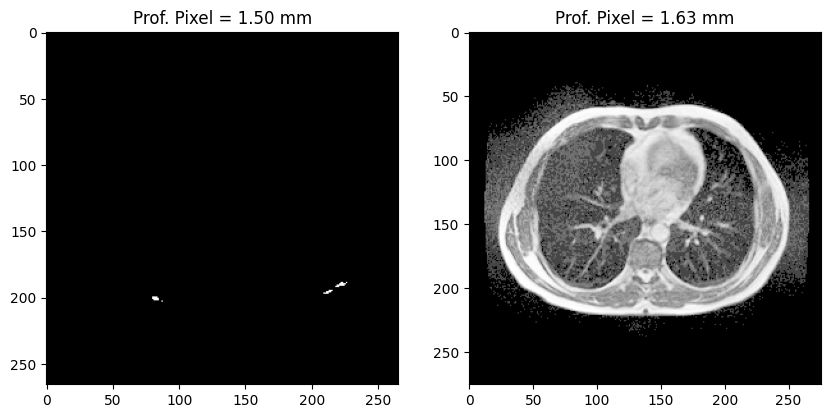

In [108]:

import cv2

im_150 = cv2.imread('../BD-Image-Segmentation-Comp/train/case2/case2_day1/scans/slice_0012_266_266_1.50_1.50.png')
im_163 = cv2.imread('../BD-Image-Segmentation-Comp/train/case34/case34_day0/scans/slice_0012_276_276_1.63_1.63.png')

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.imshow(im_150)
ax2.imshow(im_163)

ax1.set_title("Prof. Pixel = 1.50 mm")
ax2.set_title("Prof. Pixel = 1.63 mm")

plt.show()

Vogliamo, pertanto continuare ad indagare sulle relazioni legate alla profondità dei pixel.

## RELAZIONI TRA PROFONDIT&Agrave; DEI PIXEL E DIMENSIONI DELL'IMMAGINE

In questa seconda parte dell'indagine statistica, vogliamo andare a vedere anche quale sia l'associazione tra la dimensione dei pixel e la risultante dimensione complessiva dell'immagine, così come se questa possa avere un layout quadrato o in landscape.

Per poter fare delle considerazioni, dobbiamo innanzitutto, vedere, per ogni dimensione del pixel, quali valori di altezza e larghezza globali si ottengono.

In [109]:
widths_px_1_50 = image_details[(image_details['width_px'] == 1.5) & (image_details['height_px'] == 1.5)]['width'].unique()
print(f"Le immagini associate a una profondità del pixel 1.5 mm hanno una larghezza (in pixel) tra {widths_px_1_50}")

heights_px_1_50 = image_details[(image_details['width_px'] == 1.5) & (image_details['height_px'] == 1.5)]['height'].unique()
print(f"Le immagini associate a una profondità del pixel 1.5 mm hanno un'altezza (in pixel) tra {heights_px_1_50}")

widths_px_1_63 = image_details[(image_details['width_px'] == 1.63) & (image_details['height_px'] == 1.63)]['width'].unique()
print(f"Le immagini associate a una profondità del pixel 1.63 mm hanno una larghezza (in pixel) tra {widths_px_1_63}")

heights_px_1_63 = image_details[(image_details['width_px'] == 1.63) & (image_details['height_px'] == 1.63)]['height'].unique()
print(f"Le immagini associate a una profondità del pixel 1.63 mm hanno un'altezza' (in pixel) tra {heights_px_1_63}")

Le immagini associate a una profondità del pixel 1.5 mm hanno una larghezza (in pixel) tra [266 360 234]
Le immagini associate a una profondità del pixel 1.5 mm hanno un'altezza (in pixel) tra [266 310 234]
Le immagini associate a una profondità del pixel 1.63 mm hanno una larghezza (in pixel) tra [276]
Le immagini associate a una profondità del pixel 1.63 mm hanno un'altezza' (in pixel) tra [276]


Si evince che le slice con profondità dei pixel pari a $1.50 \text{ mm}$ hanno dimensione variabile, mentre quelle a profondità pari a $1.63 \text{ mm}$ hanno tutte la stessa dimensione $\left(276\times 276\right)$ 

## STATISTICA DELLE DIMENSIONI GLOBALI DELLE IMMAGINI

Visto quanto provato nel paragrafo precedente, abbiamo pensato avesse senso indagare su quali fossero le dimensioni delle slice nel dataset. Motivati da questa curiosità, e ricercando possibili correlazioni statistiche con la qualità dell'immagine/con la presenza di segmentazione, abbiamo individuato, per ogni dimensione, i valori corrispondenti per l'altra dimensione.

Come prima cosa, abbiamo analizzato le immagini in cui almeno una dimensione è $266 \text{ px}$:

In [110]:
num_images_266_width = image_details.loc[(image_details['width'] == 266)].shape[0]
print("Il numero di immagini con larghezza 266 px è:", num_images_266_width)

num_images_266_height = image_details.loc[(image_details['height'] == 266)].shape[0]
print("Il numero di immagini con altezza 266 px è:", num_images_266_height)

num_images_266x266 = image_details.loc[(image_details['width'] == 266) & (image_details['height'] == 266)].shape[0]
print("Il numero di immagini 266x266 è:", num_images_266x266)

Il numero di immagini con larghezza 266 px è: 25920
Il numero di immagini con altezza 266 px è: 25920
Il numero di immagini 266x266 è: 25920


Ne abbiamo dedotto che le immagini con altezza o larghezza $266 \text{ px}$ sono **quadrate**. Abbiamo, quindi, continuato l'analisi con le immagini in cui almeno una dimensione era $234 \text{ px}$:

In [111]:
num_images_234_width = image_details.loc[(image_details['width'] == 234)].shape[0]
print("Il numero di immagini con larghezza 234 px è:", num_images_234_width)

num_images_234_height = image_details.loc[(image_details['height'] == 234)].shape[0]
print("Il numero di immagini con altezza 234 px è:", num_images_234_height)

num_images_234x234 = image_details.loc[(image_details['width'] == 234) & (image_details['height'] == 234)].shape[0]
print("Il numero di immagini 234x234 è:", num_images_234x234)

Il numero di immagini con larghezza 234 px è: 144
Il numero di immagini con altezza 234 px è: 144
Il numero di immagini 234x234 è: 144


Anche qui, si è evidenziato come una dimensione a $234 \text{ px}$ sia associata a immagini **quadrate**. &Egrave; banale affermare che le rimanenti immagini a profondità $1.50 \text{ mm}$ sono **rettangolari** $\left( 360\times 310 \right)$.<br>
Nel seguente listato, andiamo a provare quanto affermato:

In [112]:
num_images_360_width = image_details.loc[(image_details['width'] == 360)].shape[0]
print(f"Il numero di immagini con larghezza 360 px è: {num_images_360_width}")

num_images_310_height = image_details.loc[(image_details['height'] == 310)].shape[0]
print(f"Il numero di immagini con altezza 310 px è: {num_images_310_height}")

num_images_360x310 = image_details.loc[(image_details['width'] == 360) & (image_details['height'] == 310)].shape[0]
print(f"Il numero di immagini 360x310 è: {num_images_360x310}")

tot_slice = num_images_266x266 + num_images_234x234 + num_images_360x310
print(f"Il totale delle slice con profondità dei pixel di 1.50 mm è: {tot_slice}")

Il numero di immagini con larghezza 360 px è: 11232
Il numero di immagini con altezza 310 px è: 11232
Il numero di immagini 360x310 è: 11232
Il totale delle slice con profondità dei pixel di 1.50 mm è: 37296


Adesso mostriamo, graficamente, quanto affermato in questa sezione.

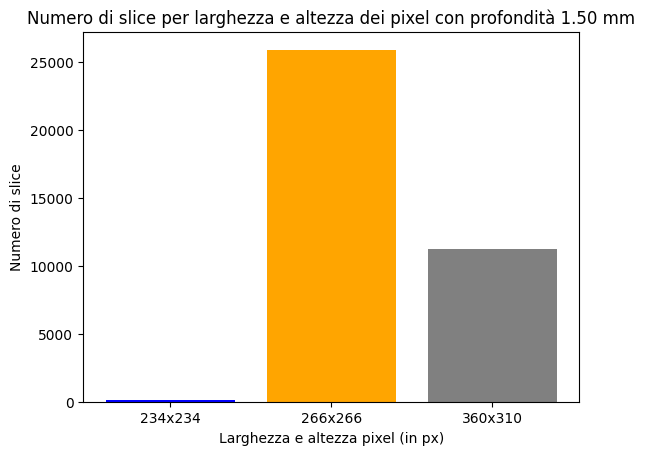

In [113]:
labels = ['234x234', '266x266', '360x310']
num_slices = [num_images_234x234, num_images_266x266, num_images_360x310]
colors = ['blue', 'orange', 'grey']

plt.bar(labels, num_slices, color=colors)
plt.title('Numero di slice per larghezza e altezza dei pixel con profondità 1.50 mm')
plt.xlabel('Larghezza e altezza pixel (in px)')
plt.ylabel('Numero di slice')

plt.show()

## STATISTICA DELLA SEGMENTAZIONE

Avendo evidenziato quelle che sono le possibili dimensioni per le slice del dataset, abbiamo pensato fosse utile ricercare quante immagini, per ogni dimensione, presentassero segmentazione, cercando di trovare una qualche correlazione con la qualità dell'immagine.

Dal dataframe *image_details* abbiamo estratto le righe le cui slice hanno data dimensione e abbiamo calcolato i numeri relativi alla segmentazione:

* $234\times234$

In [114]:
image_details_234x234 = image_details[(image_details['width'] == 234) & (image_details['height'] == 234)].reset_index().drop(columns='index')
image_details_234x234.head()

,path,mask_path,case_id,day_id,slice_name,slice_id,width,height,width_px,height_px
0,../BD-Image-Segmentation-Comp/train/case139/ca...,../BD-Image-Segmentation-Comp/train/case139/ca...,139,0,slice_0001_234_234_1.50_1.50.png,1,234,234,1.5,1.5
1,../BD-Image-Segmentation-Comp/train/case139/ca...,../BD-Image-Segmentation-Comp/train/case139/ca...,139,0,slice_0002_234_234_1.50_1.50.png,2,234,234,1.5,1.5
2,../BD-Image-Segmentation-Comp/train/case139/ca...,../BD-Image-Segmentation-Comp/train/case139/ca...,139,0,slice_0003_234_234_1.50_1.50.png,3,234,234,1.5,1.5
3,../BD-Image-Segmentation-Comp/train/case139/ca...,../BD-Image-Segmentation-Comp/train/case139/ca...,139,0,slice_0004_234_234_1.50_1.50.png,4,234,234,1.5,1.5
4,../BD-Image-Segmentation-Comp/train/case139/ca...,../BD-Image-Segmentation-Comp/train/case139/ca...,139,0,slice_0005_234_234_1.50_1.50.png,5,234,234,1.5,1.5


In [115]:
image_details_234x234_w_seg = image_details_234x234.merge(train_df, on=['case_id', 'day_id', 'slice_id']).drop_duplicates()

count_234 = 0
for i in range(len(image_details_234x234_w_seg)):
    is_nan = True
    for j in range(len(image_details_234x234_w_seg['segmentation'][i])):
        if not pd.isna(image_details_234x234_w_seg['segmentation'][i][j]):
            is_nan = False
            break
    if is_nan:
        count_234 += 1

segmented_234 = image_details_234x234_w_seg.shape[0] - count_234

print(f"\nIl numero di righe con colonna 'segmentation' diversa da (nan, nan, nan) è {segmented_234}.")
print(f"\nIl numero delle righe totali è {image_details_234x234.shape[0]}.")
print(f"\nCi sono esattamente {count_234} slice di dimensione 234x234 con maschere totalmente vuote.")
print(f"\nLa percentuale di slice di dimensione 234x234 con maschere totalmente vuote è pari al {round(count_234/image_details_234x234_w_seg.shape[0]*100, 4)}%")


Il numero di righe con colonna 'segmentation' diversa da (nan, nan, nan) è 56.

Il numero delle righe totali è 144.

Ci sono esattamente 88 slice di dimensione 234x234 con maschere totalmente vuote.

La percentuale di slice di dimensione 234x234 con maschere totalmente vuote è pari al 61.1111%


* $266\times266$

In [116]:
image_details_266x266 = image_details[(image_details['width'] == 266) & (image_details['height'] == 266)].reset_index().drop(columns='index')
image_details_266x266.head()

,path,mask_path,case_id,day_id,slice_name,slice_id,width,height,width_px,height_px
0,../BD-Image-Segmentation-Comp/train/case2/case...,../BD-Image-Segmentation-Comp/train/case2/case...,2,1,slice_0001_266_266_1.50_1.50.png,1,266,266,1.5,1.5
1,../BD-Image-Segmentation-Comp/train/case2/case...,../BD-Image-Segmentation-Comp/train/case2/case...,2,1,slice_0002_266_266_1.50_1.50.png,2,266,266,1.5,1.5
2,../BD-Image-Segmentation-Comp/train/case2/case...,../BD-Image-Segmentation-Comp/train/case2/case...,2,1,slice_0003_266_266_1.50_1.50.png,3,266,266,1.5,1.5
3,../BD-Image-Segmentation-Comp/train/case2/case...,../BD-Image-Segmentation-Comp/train/case2/case...,2,1,slice_0004_266_266_1.50_1.50.png,4,266,266,1.5,1.5
4,../BD-Image-Segmentation-Comp/train/case2/case...,../BD-Image-Segmentation-Comp/train/case2/case...,2,1,slice_0005_266_266_1.50_1.50.png,5,266,266,1.5,1.5


In [132]:
image_details_266x266_w_seg = image_details_266x266.merge(train_df, on=['case_id', 'day_id', 'slice_id']).drop_duplicates()

count_266 = 0
for i in range(len(image_details_266x266_w_seg)):
    is_nan = True
    for j in range(len(image_details_266x266_w_seg['segmentation'][i])):
        if not pd.isna(image_details_266x266_w_seg['segmentation'][i][j]):
            is_nan = False
            break
    if is_nan:
        count_266 += 1

segmented_266 = image_details_266x266_w_seg.shape[0] - count_266

print(f"\nIl numero di record con l'attributo 'segmentation' diversa da (nan, nan, nan) è {segmented_266}.")
print(f"\nIl numero di record totali è {image_details_266x266_w_seg.shape[0]}.")
print(f"\nCi sono esattamente {count_266} slice di dimensione 266x266 con maschere totalmente vuote.")
print(f"\nLa percentuale di slice di dimensione 266x266 con maschere totalmente vuote è pari al {round(count_266/image_details_266x266_w_seg.shape[0]*100, 4)}%")


Il numero di record con l'attributo 'segmentation' diversa da (nan, nan, nan) è 10955.

Il numero di record totali è 25920.

Ci sono esattamente 14965 slice di dimensione 266x266 con maschere totalmente vuote.

La percentuale di slice di dimensione 266x266 con maschere totalmente vuote è pari al 57.7353%


* $276\times276$

In [118]:
image_details_276x276 = image_details[(image_details['width'] == 276) & (image_details['height'] == 276)].reset_index().drop(columns='index')
image_details_276x276.head()

,path,mask_path,case_id,day_id,slice_name,slice_id,width,height,width_px,height_px
0,../BD-Image-Segmentation-Comp/train/case34/cas...,../BD-Image-Segmentation-Comp/train/case34/cas...,34,0,slice_0001_276_276_1.63_1.63.png,1,276,276,1.63,1.63
1,../BD-Image-Segmentation-Comp/train/case34/cas...,../BD-Image-Segmentation-Comp/train/case34/cas...,34,0,slice_0002_276_276_1.63_1.63.png,2,276,276,1.63,1.63
2,../BD-Image-Segmentation-Comp/train/case34/cas...,../BD-Image-Segmentation-Comp/train/case34/cas...,34,0,slice_0003_276_276_1.63_1.63.png,3,276,276,1.63,1.63
3,../BD-Image-Segmentation-Comp/train/case34/cas...,../BD-Image-Segmentation-Comp/train/case34/cas...,34,0,slice_0004_276_276_1.63_1.63.png,4,276,276,1.63,1.63
4,../BD-Image-Segmentation-Comp/train/case34/cas...,../BD-Image-Segmentation-Comp/train/case34/cas...,34,0,slice_0005_276_276_1.63_1.63.png,5,276,276,1.63,1.63


In [119]:
image_details_276x276_w_seg = image_details_276x276.merge(train_df, on=['case_id', 'day_id', 'slice_id']).drop_duplicates()

count_276 = 0
for i in range(len(image_details_276x276_w_seg)):
    is_nan = True
    for j in range(len(image_details_276x276_w_seg['segmentation'][i])):
        if not pd.isna(image_details_276x276_w_seg['segmentation'][i][j]):
            is_nan = False
            break
    if is_nan:
        count_276 += 1

segmented_276 = image_details_276x276_w_seg.shape[0] - count_276

print(f"\nIl numero di record con l'attributo 'segmentation' diversa da (nan, nan, nan) è {segmented_276}.")
print(f"\nIl numero dei record totali è {image_details_276x276_w_seg.shape[0]}.")
print(f"\nCi sono esattamente {count_276} slice di dimensione 276x276 con maschere totalmente vuote.")
print(f"\nLa percentuale di slice di dimensione 276x276 con maschere totalmente vuote è pari al {round(count_276/image_details_276x276_w_seg.shape[0]*100)}%")


Il numero di righe con colonna 'segmentation' diversa da (nan, nan, nan) è 718.

Il numero delle righe totali è 1200.

Ci sono esattamente 482 slice di dimensione 276x276 con maschere totalmente vuote.

La percentuale di slice di dimensione 276x276 con maschere totalmente vuote è pari al 40%


* $360\times310$

In [120]:
image_details_360x310 = image_details[(image_details['width'] == 360) & (image_details['height'] == 310)].reset_index().drop(columns='index')
image_details_360x310.head()

,path,mask_path,case_id,day_id,slice_name,slice_id,width,height,width_px,height_px
0,../BD-Image-Segmentation-Comp/train/case6/case...,../BD-Image-Segmentation-Comp/train/case6/case...,6,0,slice_0001_360_310_1.50_1.50.png,1,360,310,1.5,1.5
1,../BD-Image-Segmentation-Comp/train/case6/case...,../BD-Image-Segmentation-Comp/train/case6/case...,6,0,slice_0002_360_310_1.50_1.50.png,2,360,310,1.5,1.5
2,../BD-Image-Segmentation-Comp/train/case6/case...,../BD-Image-Segmentation-Comp/train/case6/case...,6,0,slice_0003_360_310_1.50_1.50.png,3,360,310,1.5,1.5
3,../BD-Image-Segmentation-Comp/train/case6/case...,../BD-Image-Segmentation-Comp/train/case6/case...,6,0,slice_0004_360_310_1.50_1.50.png,4,360,310,1.5,1.5
4,../BD-Image-Segmentation-Comp/train/case6/case...,../BD-Image-Segmentation-Comp/train/case6/case...,6,0,slice_0005_360_310_1.50_1.50.png,5,360,310,1.5,1.5


In [121]:
image_details_360x310_w_seg = image_details_360x310.merge(train_df, on=['case_id', 'day_id', 'slice_id']).drop_duplicates()

count_360 = 0
for i in range(len(image_details_360x310_w_seg)):
    is_nan = True
    for j in range(len(image_details_360x310_w_seg['segmentation'][i])):
        if not pd.isna(image_details_360x310_w_seg['segmentation'][i][j]):
            is_nan = False
            break
    if is_nan:
        count_360 += 1
        
segmented_360 = image_details_360x310_w_seg.shape[0] - count_360

print(f"\nIl numero di record con l'attributo 'segmentation' diversa da (nan, nan, nan) è {segmented_360}.")
print(f"\nIl numero di record totali è {image_details_360x310_w_seg.shape[0]}.")
print(f"\nCi sono esattamente {count_360} slice di dimensione 360x310 con maschere totalmente vuote.")
print(f"\nLa percentuale di slice di dimensione 360x310 con maschere totalmente vuote è pari al {round(count_360/image_details_360x310_w_seg.shape[0]*100)}%")


Il numero di righe con colonna 'segmentation' diversa da (nan, nan, nan) è 4861.

Il numero delle righe totali è 11232.

Ci sono esattamente 6371 slice di dimensione 360x310 con maschere totalmente vuote.

La percentuale di slice di dimensione 360x310 con maschere totalmente vuote è pari al 57%


Si evince che:

1.  le immagini che contengono, in percentuale, la **maggior frequenza di segmentazioni** sono quelle da $276\times276$ ($60\ \%$);
2.  le immagini che congengono la **maggior frequenza di segmentazioni totalmente vuote** sono quelle da $234\times234$ ($61.1111\ \%$);
3.  le immagini che contengono il **maggior numero di immagini segmentate**, in valore assoluto, sono quelle da $266\times266$  ($10955$);
4.  le immagini che contengono il **minor numero di immagini segmentate** sono quelle da $234\times234$ ($56$).

Osserviamo graficamente, quanto visto analiticamente:


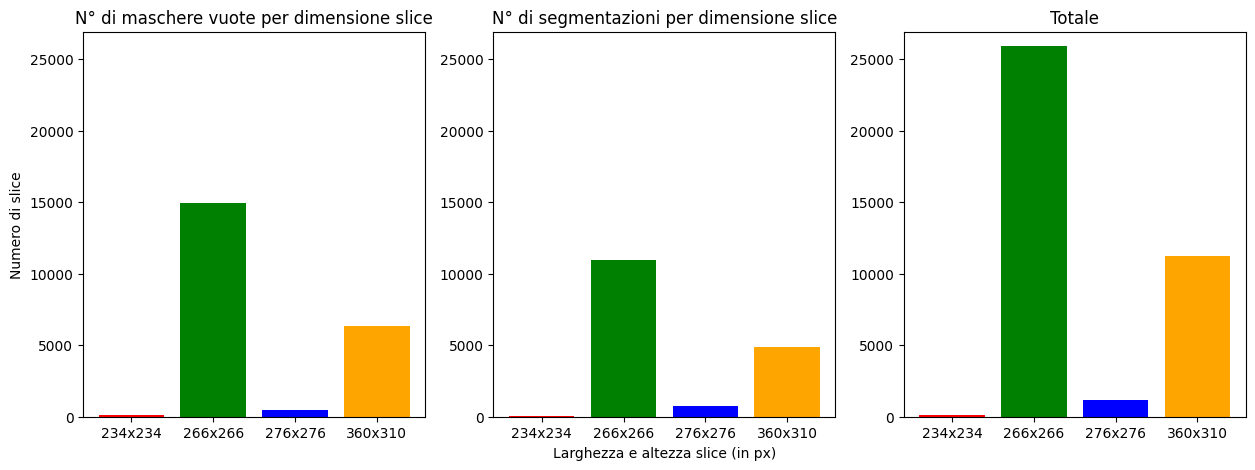

In [122]:
labels = ['234x234', '266x266', '276x276', '360x310']
counters1 = [count_234, count_266, count_276, count_360]
counters2 = [segmented_234, segmented_266, segmented_276, segmented_360]
counters3 = [(count_234 + segmented_234), (count_266 + segmented_266), (count_276 + segmented_276), (count_360 + segmented_360)]
colors = ['red', 'green', 'blue', 'orange']
lower_bound = 0
upper_bound = count_266 + segmented_266 + 1000

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

ax1.bar(labels, counters1, color=colors)
ax1.set_ybound(lower_bound, upper_bound)
ax1.set_title('N° di maschere vuote per dimensione slice')
ax1.set_ylabel('Numero di slice')

ax2.bar(labels, counters2, color=colors)
ax2.set_ybound(lower_bound, upper_bound)
ax2.set_title('N° di segmentazioni per dimensione slice')
ax2.set_xlabel('Larghezza e altezza slice (in px)')

ax3.bar(labels, counters3, color=colors)
ax3.set_ybound(lower_bound, upper_bound)
ax3.set_title('Totale')

plt.show()

# <center>4 &dash; OPERAZIONI SULLE MASCHERE</center>

Avendo visto, nei paragrafi precedenti, l'esistenza di una colonna per la segmentazione degli organi all'interno delle scansioni e dopo averne evidenziato la distribuzione, in funzione delle dimensioni delle immagini, in questa sezione ci occuperemo di tutte le operazioni che abbiamo ritenuto necessarie per l'elaborazione delle maschere.

Come stabilito in fase di presentazione della competizione, le maschere di segmentazione del training set sono state fornite secondo la codifica **run-length**. 

Questa codifica (da ora RLE) è una semplice forma di **compressione** dei dati **senza perdita** di informazioni, che viene eseguita su sequenze con lo stesso valore che si verificano più volte consecutive. Codifica la sequenza per memorizzare un solo valore e il relativo conteggio.

Consideriamo, ad esempio, una porzione di maschera presa dal file `train.csv`:
**<center>24031 5 24296 7 24561 8 24825 10</center>** 

Contando da 0, gli elementi di posto **pari** indicano la posizione dei vari pixel nell'immagine vettorizzata, mentre gli elementi di posto **dispari** indicano la **lunghezza della run**, ovvero quante volte (meno uno) deve essere ripetuto il valore del pixel di riferimento.

Nel nostro esempio, il pixel **24031** andrà ripetuto **4** volte, il pixel **24296** andrà ripetuto **6** volte e così via.

Per sfruttare la codifica RLE delle maschere, procediamo all'implementazione delle funzioni per:

* creare una maschera vuota
* decodificare una stringa RLE
* codificare un'immagine in una stringa RLE

Tali funzioni sulle maschere sono state implementate in un modulo chiamato `mask_ops`.

## CREAZIONE MASCHERA VUOTA

In [123]:
def crea_maschera_vuota(path: str, width: int, height: int):
    """Funzione usata per creare un segnaposto per una maschera
    in un dato percorso

    Args:
        path (str): percorso in cui salvare la maschera vuota
        width (int): larghezza desiderata per la maschera
        height (int): altezza desiderata per la maschera
    """
    # Creo una maschera vuota con le dimensioni dei pixel calcolate
    mask = np.zeros((height, width, 3), dtype=np.uint8)

    cv.imwrite(path, mask)

&Egrave; una funzione molto semplice che serve a generare una maschera di larghezza e altezza desiderate, e a salvarla nel percorso specificato.

Tornerà utile per generare le maschere presenti nel dataset.

## DECODIFICA **RLE**

In [124]:
def rle_to_image(rle_code: str, height: int, width: int) -> np.ndarray:
    """Funzione usata per convertire una maschera codificata RLE in 
    un'immagine di data altezza e larghezza

    Args:
        rle_code (str): stringa rappresentativa della segmentazione RLE
        height (int): altezza desiderata per l'immagine
        width (int): larghezza desiderata per l'immagine

    Returns:
        np.ndarray: immagine della maschera associata alla stringa RLE
    """
    # Verifica se la codifica è 'nan'
    
    if isinstance(rle_code, float) and math.isnan(rle_code):
        return np.zeros((height, width), dtype=np.uint8)
    
    # Trasforma la stringa in una lista di numeri interi e genera
    # un array NumPy fatto da coppie di interi (secondo la notazione RLE)
    rle_numbers = [int(i) for i in rle_code.split()]
    rle_pairs = np.array(rle_numbers).reshape(-1, 2)

    # Crea un'immagine vuota
    img = np.zeros(height*width, dtype=np.uint8)

    # Colora i pixel coperti dalla maschera
    for index, length in rle_pairs:
        index -= 1
        img[index:index+length] = 255

    # Ridimensiona l'immagine e la restituisce
    return img.reshape((height, width))

Osserviamo, in questo esempio, la funzione al lavoro:

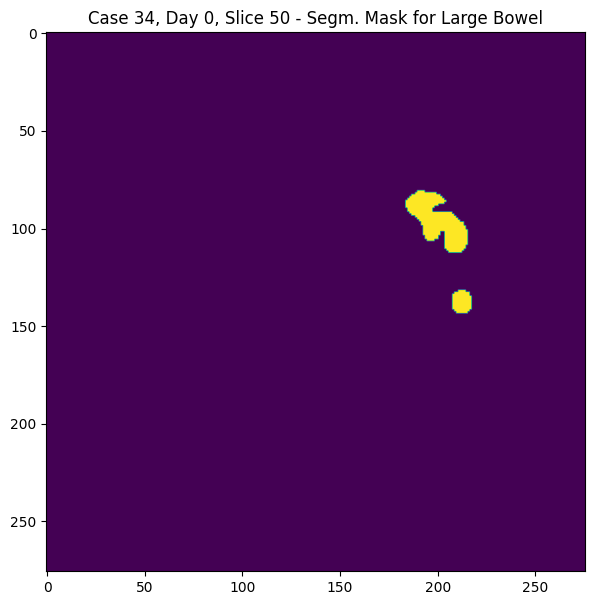

In [125]:
rle_string = '22547 4 22822 11 23096 15 23371 17 23646 19 23921 21 24197 20 24473 17 24749 15 25026 13 ' +\
'25302 13 25579 22 25856 22 26134 21 26411 21 26688 21 26965 22 27241 22 27518 22 27794 22 28070 23 ' +\
'28346 9 28357 12 28622 9 28633 12 28899 7 28909 12 29175 7 29185 12 29452 4 29461 12 29737 12 30013 12 ' +\
'30289 11 30565 11 30842 9 31119 7 36644 4 36918 8 37193 9 37469 10 37745 10 38021 10 38297 10 38573 10 ' +\
'38849 10 39125 10 39402 8 39679 6'

rle_dec_width = 276
rle_dec_height = 276

rle_dec_mask = rle_to_image(rle_string, rle_dec_height, rle_dec_width)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(7,7))

ax.set_title('Case 34, Day 0, Slice 50 - Segm. Mask for Large Bowel')

plt.imshow(rle_dec_mask)
plt.show()


## CODIFICA **RLE**

In [126]:
def rle_encode(mask: np.ndarray) -> str:
    """Funzione usata per generare una codifica RLE a partire da una maschera binaria

    Args:
        mask (np.ndarray): maschera binaria da codificare in RLE

    Returns:
        str: codifica RLE della maschera
    """
    
    rle_string = ""
    
    mask = mask.flatten()

    # Si aggiunge uno zero-padding alla maschera per evitare problemi di indicizzazione
    padded_mask = np.pad(mask, (1,), mode="constant")

    # Inizializza l'indice corrente a 0
    current_index = 0
    
    # Inizializza la lunghezza corrente a 0
    current_length = 0

    # Itera attraverso ciascun pixel della riga
    for pixel in padded_mask:
        # Se il pixel è 1 e il pixel precedente era 0, inizia una nuova sequenza
        if pixel == 1 and padded_mask[current_index - 1] == 0:
            rle_string += str(current_index) + " "
            current_length = 1
        # Se il pixel è 1 e il pixel precedente era 1, aumenta la lunghezza della sequenza corrente
        elif pixel == 1 and padded_mask[current_index - 1] == 1:
            current_length += 1
        # Se il pixel è 0 e il pixel precedente era 1, termina la sequenza corrente
        elif pixel == 0 and padded_mask[current_index - 1] == 1:
            rle_string += str(current_length) + " "
            current_length = 0
        
        # Incrementa l'indice corrente
        current_index += 1

    # Se c'è ancora una sequenza attiva alla fine della riga, termina la sequenza
    if current_length != 0:
        rle_string += str(current_length) + " "

    # Restituisci la stringa RLE
    return rle_string

Osserviamo, in quello che segue, come la funzione codifichi esattamente la maschera dell'esempio precedente

In [127]:
encoded_mask = rle_encode(rle_dec_mask/255)

print(f"Maschera codificata come:\n{encoded_mask}\n")


print(f"Stringa originale:\n{rle_string}\n")

Maschera codificata come:
22547 4 22822 11 23096 15 23371 17 23646 19 23921 21 24197 20 24473 17 24749 15 25026 13 25302 13 25579 22 25856 22 26134 21 26411 21 26688 21 26965 22 27241 22 27518 22 27794 22 28070 23 28346 9 28357 12 28622 9 28633 12 28899 7 28909 12 29175 7 29185 12 29452 4 29461 12 29737 12 30013 12 30289 11 30565 11 30842 9 31119 7 36644 4 36918 8 37193 9 37469 10 37745 10 38021 10 38297 10 38573 10 38849 10 39125 10 39402 8 39679 6 

Stringa originale:
22547 4 22822 11 23096 15 23371 17 23646 19 23921 21 24197 20 24473 17 24749 15 25026 13 25302 13 25579 22 25856 22 26134 21 26411 21 26688 21 26965 22 27241 22 27518 22 27794 22 28070 23 28346 9 28357 12 28622 9 28633 12 28899 7 28909 12 29175 7 29185 12 29452 4 29461 12 29737 12 30013 12 30289 11 30565 11 30842 9 31119 7 36644 4 36918 8 37193 9 37469 10 37745 10 38021 10 38297 10 38573 10 38849 10 39125 10 39402 8 39679 6



## E ADESSO?

Avendo un modo di decodificare delle stringhe RLE, vista l'enorme mole di dati e il formato *a triple* del nostro dataframe, abbiamo ritenuto una buona idea la decodifica di tutte le segmentazioni per la generazione delle maschere di ogni immagine, salvata opportunamente nella cartella determinata da `mask_path` all'interno del dataframe.

In questo modo, possiamo lavorare più immediatamente con le maschere e le immagini, senza doverle generare ad ogni esecuzione. In questo senso, abbiamo iterato su tutte le righe del dataframe **merged_df** (`row`), eseguendo la seguente porzione di codice:

```python
mask_path = row['mask_path']

red_segment = mop.rle_to_image(row['segmentation'][0], row['height'], row['width'])
green_segment = mop.rle_to_image(row['segmentation'][1], row['height'], row['width'])
blue_segment = mop.rle_to_image(row['segmentation'][2], row['height'], row['width'])

merged_mask = cv.merge([red_segment, green_segment, blue_segment])

cv.imwrite(mask_path, merged_mask)
```

Nello specifico, generiamo le maschere per ogni canale RGB (gli indici della lista corrispondono con i valori di classe), per poi unire i tre canali in un'unica immagine, rappresentativa della maschera, opportunamente salvata secondo le modalità descritte in precedenza.

<div>  

<img src="./train/case2/case2_day1/masks/mask_slice_0078_266_266_1.50_1.50.png" width="500" align="center"/>  

</div> 


L'intenzione, avendo a disposizione le maschere, è quella di sovrapporle alle immagini, in modo da avere una migliore conoscenza del dominio in cui stiamo operando (i.e. saper individuare meglio a cosa corrisponde ogni segmento).

Allo scopo, abbiamo previsto una funzione, <code>def override_mask_on_img(mask_array: np.array, rgb_slice: cv.Mat) -> cv.Mat</code> (riportata nel listato seguente).

In [128]:
def override_mask_on_img(mask_array: np.array, rgb_slice: cv.Mat) -> cv.Mat:
    """Funzione usata per sovrapporre una maschera ad un'immagine

    Args:
        mask_array (np.array): maschera da sovrapporre
        rgb_slice (Mat): immagine su cui applicare la maschera

    Returns:
        Mat: immagine con maschera sovrapposta
    """
    
    bool_index = mask_array != (0, 0, 0)

    rgb_slice[bool_index] = mask_array[bool_index]

    return rgb_slice

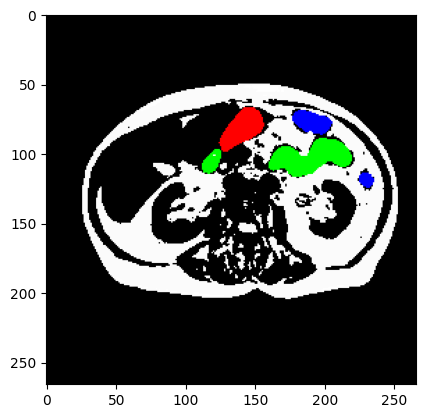

In [129]:
mask = cv.cvtColor(cv.imread('./train/case2/case2_day2/masks/mask_slice_0081_266_266_1.50_1.50.png'), cv.COLOR_BGR2RGB)

case_2_2_81 = cv.imread('./pics/2_2_81_equalised.png')

plt.imshow(override_mask_on_img(case_2_2_81, mask))
plt.show()

### Equalizzazione delle immagini

Un appunto va fatto alla qualità media delle immagini, di cui abbiamo avuto un assaggio nelle sezioni precedenti: i casi in cui sono facilmente distinguibili gli elementi dell'immagine sono pochi, mentre è più generale il caso di immagini **totalmente nere** o **poco contrastate**.

Si è reso necessario, allora, implementare una funzione che andasse a migliorare la qualità delle scansioni presenti nel dataset. Nello specifico uno strumento che ben si presta al miglioramento del contrasto per immagini monocromatiche è l'equalizzazione dell'istogramma: abbiamo pensato, infatti, che le immagini meno contrastate contenessero comunque dell'informazione e, semplicemente, la poca qualità visiva era data da un istogramma molto compattato sui neri; l'equalizzazione dell'istogramma permette di ottenere una distribuzione delle intensità **più uniforme**, con un conseguente miglioramento del contrasto.

Da un punto di vista implementativo, abbiamo definito una funzione che, dato in input il percorso dell'immagine, la equalizzasse e sovrascrivesse l'originale con la versione migliorata.

In [130]:
def equalizza_immagini(path: str):
    
    """Funzione usata per equalizzare un'immagine e sovrascriverla all'originale

    Args:
        path (str): percorso in cui salvare l'immagine
    """
    
    img = cv.imread(path, 0) 

    equ = cv.equalizeHist(img)
    
    cv.imwrite(path, equ)

Quello che abbiamo fatto è stato, quindi, iterare su tutte le righe del dataframe, equalizzando e sovrascrivendo tutte le immagini indicate in `path`, con il seguente listato:

```python
for index, row in merged_df.iterrows():
    
    if row['is_equalized'] == False:
        print(f"Inizio equalizzazione...\n")    
        
        for index, row in tqdm(merged_df.iterrows(), total=len(merged_df)):
            equalizza_immagini(row['path'])
        
        print(f"\nFine equalizzazione.\n")
        row['is_equalized'] = True
        
    else:
        print("Immagini già equalizzate")
        break
```

Il risultato dell'equalizzazione è andato oltre le aspettative, dato che immagini quasi totalmente nere (una percentuale di pixel bianchi minima) sono poi risultate in immagini qualitativamente buone, come si può vedere nell'esempio seguente.

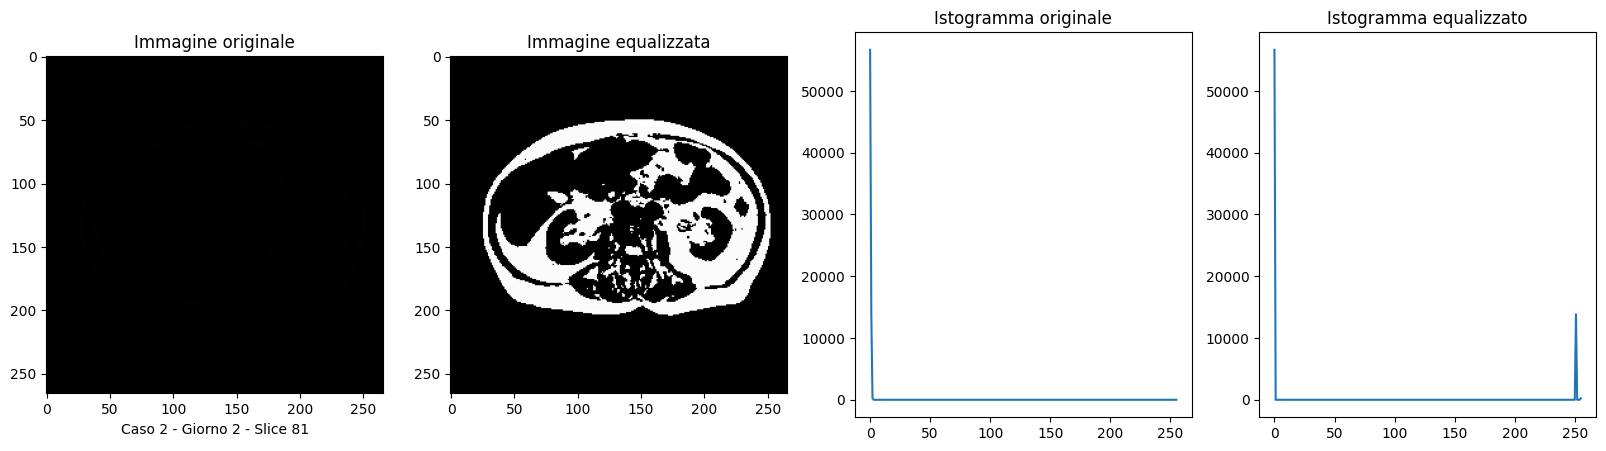

In [131]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1,4,figsize=(20,5))

ax1.set_title('Immagine originale')
ax1.set_xlabel("Caso 2 - Giorno 2 - Slice 81")
ax2.set_title('Immagine equalizzata')
ax3.set_title('Istogramma originale')
ax4.set_title('Istogramma equalizzato')

original = cv.imread('./pics/2_2_81_original.png')
equalised = cv.imread('./pics/2_2_81_equalised.png')

ax1.imshow(original)
ax2.imshow(equalised)
ax3.plot([_ for _ in range(256)], cv.calcHist([original], [0], None, [256], [0, 256]))
ax4.plot([_ for _ in range(256)], cv.calcHist([equalised], [0], None, [256], [0, 256]))

plt.show()